# Spin qubit measurement software

This example shows a typical workflow of tasks undertaken when performing spin qubit measurements.

In [1]:
import sys, os, tempfile
import numpy as np
%matplotlib inline
%gui qt
import matplotlib.pyplot as plt
import qcodes
from qcodes import MatPlot, QtPlot
import qtt
from qtt.measurements.scans import scanjob_t

# set data directory
datadir = os.path.join(tempfile.mkdtemp(), 'qdata')
qcodes.DataSet.default_io = qcodes.DiskIO(datadir)    

## Load your station

For the purpose of this example we will use a virtual system that simulates the device and instruments in a 2-dot spin-qubit dot setup. The hardware consists of a virtual multimeter (`keithley`), voltage sources (`ivvi`) and a virtual gates object (`gates`) that applies voltages to the virtual device gates.

In [2]:
import qtt.simulation.virtual_dot_array as virtual_dot

nr_dots = 2
station = virtual_dot.initialize(nr_dots=nr_dots)

keithley1 = station.keithley1
keithley3 = station.keithley3

# virtual gates for the model
gates = station.gates

initialize: create virtualdot
initialized virtual dot system (2 dots)


## Setup measurement windows

* Parameter viewer (`pv`): gui for reading and changing the values of the instruments
* Live plotting window (`plotQ`): for on-going measurements

In [3]:
pv = qtt.createParameterWidget([gates, ])
mwindows = qtt.gui.live_plotting.setupMeasurementWindows(station, create_parameter_widget=False)
plotQ = mwindows['plotwindow']   

## Read out instruments

We can, for example, readout a gate voltage or readout the voltage measured by the multimeter. We can also retrieve the full state of our measurement station using `station.snapshot()`, which returns a dictionary with every parameter of every instrument in the station. 

In [4]:
print('gate P1: %.1f, amplitude: %f' % (gates.P1.get(),  keithley3.readnext()) )
snapshotdata = station.snapshot()

gate P1: -0.5, amplitude: 0.995221


## Simple 1D scan loop

We use the `scan1D` function to measurements as we sweep one parameter. This function has `scanjob` as argument, where the parameters of the scan are set.

In [5]:
scanjob = scanjob_t({'sweepdata': dict({'param': 'P1', 'start': -500, 'end': 1, 'step': .8, 'wait_time': 1e-2}), 'minstrument': [keithley3.amplitude]})
data1d = qtt.measurements.scans.scan1D(station, scanjob, location=None, verbose=1)

scan1D: 0/627: time 0.5
scan1D: 137/627: time 2.0
scan1D: 271/627: time 3.5
scan1D: 407/627: time 5.0
scan1D: 545/627: time 6.5


## Analyse the scan

We have scripts for performing various analysis on our data (see the Analysis examples). In this example we use a script that determines the pinch-off voltage from our 1D scan.

DataSet:
   location = '2018-09-05/14-39-40_qtt_scan1D'
   <Type>   | <array_id>          | <array.name>        | <array.shape>
   Measured | keithley3_amplitude | keithley3_amplitude | (627,)
   Setpoint | P1                  | P1                  | (627,)
analyseGateSweep: pinch-off point -212.000, value 0.297


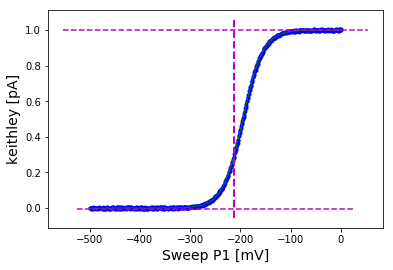

In [6]:
print( data1d )
adata = qtt.algorithms.gatesweep.analyseGateSweep(data1d, fig=100)

##  Make a 2D scan

We can also perfom scans of a 2-dimensional gate space. In this example the scan reveals the charge stability diagram of our 2-dot system.

scan2D: 0/100: time 00:00:00 (~00:00:00 remaining): setting B0 to -500.000
scan2D: 36/100: time 00:00:02 (~00:00:04 remaining): setting B0 to -356.000
scan2D: 68/100: time 00:00:03 (~00:00:01 remaining): setting B0 to -228.000


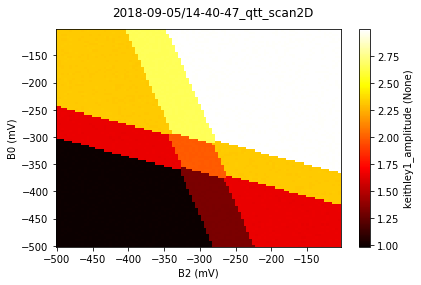

In [7]:
start=-500
scanjob = scanjob_t({'sweepdata': dict({'param': 'B2', 'start': start, 'end': start+400, 'step': 4.}), 'minstrument': ['keithley1.amplitude'], 'wait_time': 0.})
scanjob['stepdata'] = dict({'param': 'B0', 'start': start, 'end': start+400, 'step': 4.})
data = qtt.measurements.scans.scan2D(station, scanjob, liveplotwindow=plotQ)

_=qcodes.MatPlot(data.default_parameter_array())

## More analysis

(-0.5, 99.5, 99.5, -0.5)

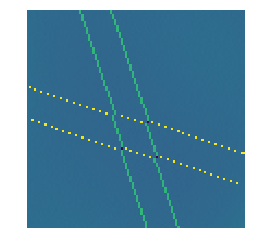

In [8]:
from qtt.utilities.imagetools import cleanSensingImage
im, tr = qtt.data.dataset2image(data)

imx=cleanSensingImage(im)
plt.imshow(imx)
plt.axis('off')

## Send data to powerpoint

We can copy data from a dataset to an open Powerpoint presentation using `qtt.tools.addPPT_dataset(dataset)`.

In [9]:
_=qtt.utilities.tools.addPPT_dataset(data, verbose=1)    

addPPTslide: presentation name: 2018_06_28 B8 D2 6thCooldown.pptx, adding slide 991


d:\jdehollainlore\git\qtt\qtt\measurements\ttrace.py:28: UserWarning: could not import pycqed, not all functionality available
  warnings.warn('could not import pycqed, not all functionality available')


 image aspect ratio 1.67, slide aspect ratio 1.33
adjust height 350->316
slide width height: [720.0, 540.0]
image width height: 528, 316


We have a GUI for easy browsing of our saved datasets.

In [10]:
logviewer = qtt.gui.dataviewer.DataViewer(datadir=datadir, verbose=1)

findfilesR: D:\jdehollainlore\AppData\Local\Temp\tmpgjuj_rq9\qdata: 0.0%
DataViewer: found 2 files


We can fetch the active dataset from the viewer:

In [11]:
dataset = logviewer.dataset
print( dataset )

DataSet:
   location = 'D:\\jdehollainlore\\AppData\\Local\\Temp\\tmpgjuj_rq9\\qdata\\2018-09-05\\14-40-47_qtt_scan2D'
   <Type>   | <array_id>          | <array.name> | <array.shape>
   Setpoint | B0                  | None         | (100,)
   Setpoint | B2                  | None         | (100, 100)
   Measured | keithley1_amplitude | None         | (100, 100)
